In [52]:
import pandas as pd
import os
import numpy as np

In [86]:
os.getcwd()

'C:\\Users\\Richard\\Downloads'

In [87]:
df=pd.read_csv('NSE Training Data - 1st Jan 2016 to 1st Jan 2022.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,7924.549805,7937.549805,7781.100098,7791.299805,7791.299805,134700.0
1,2016-01-05,7828.399902,7831.200195,7763.250000,7784.649902,7784.649902,145200.0
2,2016-01-06,7788.049805,7800.950195,7721.200195,7741.000000,7741.000000,147100.0
3,2016-01-07,7673.350098,7674.950195,7556.600098,7568.299805,7568.299805,188900.0
4,2016-01-08,7611.649902,7634.100098,7581.049805,7601.350098,7601.350098,157400.0
...,...,...,...,...,...,...,...
1476,2021-12-27,16937.750000,17112.050781,16833.199219,17086.250000,17086.250000,144800.0
1477,2021-12-28,17177.599609,17250.250000,17161.150391,17233.250000,17233.250000,176000.0
1478,2021-12-29,17220.099609,17285.949219,17176.650391,17213.599609,17213.599609,161700.0
1479,2021-12-30,17201.449219,17264.050781,17146.349609,17203.949219,17203.949219,320800.0


In [88]:
df.shape

(1481, 7)

In [92]:
df.isnull().sum()


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [91]:
df.dropna(how = 'any', inplace = True)

In [93]:
df1=df.reset_index()['Close']
df1

0        7791.299805
1        7784.649902
2        7741.000000
3        7568.299805
4        7601.350098
            ...     
1470    17086.250000
1471    17233.250000
1472    17213.599609
1473    17203.949219
1474    17354.050781
Name: Close, Length: 1475, dtype: float64

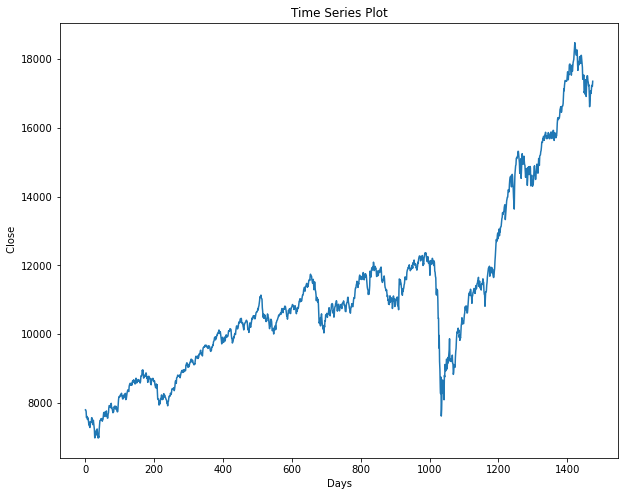

In [95]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,8))
plt.plot(df1.index.values, df['Close'])
plt.title("Time Series Plot")
plt.xlabel("Days")
plt.ylabel(" Close")
plt.show()

In [ ]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler 

In [96]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [97]:
print(df1)

[[0.07132518]
 [0.07074726]
 [0.06695374]
 ...
 [0.89019627]
 [0.88935758]
 [0.90240257]]


In [98]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [99]:
training_size,test_size

(958, 517)

In [100]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [101]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [102]:
print(X_train.shape), print(y_train.shape)

(857, 100)
(857,)


(None, None)

In [103]:
print(X_test.shape), print(ytest.shape)

(416, 100)
(416,)


(None, None)

In [104]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [105]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [106]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [107]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [108]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 19s 595ms/step - loss: 0.0127 - val_loss: 0.0639
Epoch 2/100
14/14 [==============================] - 5s 381ms/step - loss: 0.0022 - val_loss: 0.0410
Epoch 3/100
14/14 [==============================] - 5s 386ms/step - loss: 0.0014 - val_loss: 0.0176
Epoch 4/100
14/14 [==============================] - 5s 381ms/step - loss: 6.2243e-04 - val_loss: 0.0075
Epoch 5/100
14/14 [==============================] - 5s 377ms/step - loss: 4.4376e-04 - val_loss: 0.0046
Epoch 6/100
14/14 [==============================] - 5s 389ms/step - loss: 4.1206e-04 - val_loss: 0.0052
Epoch 7/100
14/14 [==============================] - 5s 386ms/step - loss: 4.0654e-04 - val_loss: 0.0046
Epoch 8/100
14/14 [==============================] - 5s 377ms/step - loss: 3.9471e-04 - val_loss: 0.0048
Epoch 9/100
14/14 [==============================] - 5s 388ms/step - loss: 3.9944e-04 - val_loss: 0.0036
Epoch 10/100
14/14 [==============================] - 5s 383ms/ste

14/14 [==============================] - 5s 384ms/step - loss: 2.0336e-04 - val_loss: 0.0034
Epoch 79/100
14/14 [==============================] - 5s 376ms/step - loss: 2.2172e-04 - val_loss: 0.0040
Epoch 80/100
14/14 [==============================] - 5s 374ms/step - loss: 1.8760e-04 - val_loss: 0.0035
Epoch 81/100
14/14 [==============================] - 5s 379ms/step - loss: 1.8069e-04 - val_loss: 0.0037
Epoch 82/100
14/14 [==============================] - 5s 385ms/step - loss: 1.8807e-04 - val_loss: 0.0026
Epoch 83/100
14/14 [==============================] - 5s 378ms/step - loss: 1.8432e-04 - val_loss: 0.0026
Epoch 84/100
14/14 [==============================] - 5s 389ms/step - loss: 1.7460e-04 - val_loss: 0.0042
Epoch 85/100
14/14 [==============================] - 5s 378ms/step - loss: 1.8311e-04 - val_loss: 0.0053
Epoch 86/100
14/14 [==============================] - 5s 381ms/step - loss: 1.7455e-04 - val_loss: 0.0028
Epoch 87/100
14/14 [==============================] - 5s 38

In [109]:
import tensorflow as tf

In [113]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [111]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [114]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.012281896291019667

In [115]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

0.0516818244784449

In [116]:
len(test_data)

517

In [121]:
x_input=test_data[417:].reshape(1,-1)
x_input.shape


(1, 100)

In [122]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [123]:
temp_input

[0.8071689661627691,
 0.809067867014296,
 0.8092547527064388,
 0.8163942602108137,
 0.8307079024048688,
 0.8336585231423445,
 0.8381385169666918,
 0.8341624863678218,
 0.8238769854552898,
 0.8278703297337199,
 0.8390075946932211,
 0.8398810857702607,
 0.8400766282587299,
 0.8460123272750134,
 0.8656405834786126,
 0.8831219461978027,
 0.8782595241928434,
 0.8919822954756759,
 0.8997561277776,
 0.9044666309112969,
 0.9031020770247365,
 0.9023547041608607,
 0.903723501580144,
 0.9025112060266066,
 0.9046577601361626,
 0.9167769811576393,
 0.926341249413062,
 0.9224869236768446,
 0.9061265354749358,
 0.920474974758991,
 0.919140974429708,
 0.9431534901577953,
 0.9457824502805455,
 0.9459476089426176,
 0.9366919311550835,
 0.9334503730910398,
 0.9253548801743904,
 0.917872154843007,
 0.9317078043743786,
 0.9430971358555121,
 0.9277752276618348,
 0.9403203306633422,
 0.9494325767319675,
 0.9538431461941023,
 0.9578409037361358,
 0.9725979114075692,
 0.9879632734875731,
 1.0,
 0.9949332089793

In [125]:
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [0.91914097 0.94315349 0.94578245 0.94594761 0.93669193 0.93345037
 0.92535488 0.91787215 0.9317078  0.94309714 0.92777523 0.94032033
 0.94943258 0.95384315 0.9578409  0.97259791 0.98796327 1.
 0.99493321 0.98171016 0.97401882 0.96852632 0.96943885 0.98186666
 0.97687371 0.94613449 0.93000445 0.95242665 0.9488894  0.94369666
 0.95130992 0.96449817 0.96238625 0.96003532 0.9475554  0.96747035
 0.96805257 0.95847099 0.94973251 0.93809994 0.90783431 0.9153778
 0.90770395 0.9182371  0.87393145 0.87632141 0.87017269 0.88613775
 0.90653935 0.8887275  0.86400665 0.88698934 0.91245773 0.91655105
 0.91606882 0.90363659 0.89986918 0.89087422 0.89322073 0.8703465
 0.83810372 0.85171786 0.867761   0.87794228 0.87195871 0.8791286
 0.89190404 0.89019627 0.88935758 0.90240257 0.81690681 0.81029022
 0.79221869 0.76711345 0.73817742 0.70734459 0.67573905 0.64407277
 0.61287028 0.58256328 0.55351722 0.52603149 0.50033581 0.47658861
 0.45488128 0.43524435 0.4176572  0.40205669 0.38834703 0.376

8 day output [[0.32175827]]
9 day input [0.94309714 0.92777523 0.94032033 0.94943258 0.95384315 0.9578409
 0.97259791 0.98796327 1.         0.99493321 0.98171016 0.97401882
 0.96852632 0.96943885 0.98186666 0.97687371 0.94613449 0.93000445
 0.95242665 0.9488894  0.94369666 0.95130992 0.96449817 0.96238625
 0.96003532 0.9475554  0.96747035 0.96805257 0.95847099 0.94973251
 0.93809994 0.90783431 0.9153778  0.90770395 0.9182371  0.87393145
 0.87632141 0.87017269 0.88613775 0.90653935 0.8887275  0.86400665
 0.88698934 0.91245773 0.91655105 0.91606882 0.90363659 0.89986918
 0.89087422 0.89322073 0.8703465  0.83810372 0.85171786 0.867761
 0.87794228 0.87195871 0.8791286  0.89190404 0.89019627 0.88935758
 0.90240257 0.81690681 0.81029022 0.79221869 0.76711345 0.73817742
 0.70734459 0.67573905 0.64407277 0.61287028 0.58256328 0.55351722
 0.52603149 0.50033581 0.47658861 0.45488128 0.43524435 0.4176572
 0.40205669 0.38834703 0.37640896 0.36610752 0.357299   0.34983698
 0.34357679 0.33837926 0.3

16 day output [[0.3256904]]
17 day input [1.         0.99493321 0.98171016 0.97401882 0.96852632 0.96943885
 0.98186666 0.97687371 0.94613449 0.93000445 0.95242665 0.9488894
 0.94369666 0.95130992 0.96449817 0.96238625 0.96003532 0.9475554
 0.96747035 0.96805257 0.95847099 0.94973251 0.93809994 0.90783431
 0.9153778  0.90770395 0.9182371  0.87393145 0.87632141 0.87017269
 0.88613775 0.90653935 0.8887275  0.86400665 0.88698934 0.91245773
 0.91655105 0.91606882 0.90363659 0.89986918 0.89087422 0.89322073
 0.8703465  0.83810372 0.85171786 0.867761   0.87794228 0.87195871
 0.8791286  0.89190404 0.89019627 0.88935758 0.90240257 0.81690681
 0.81029022 0.79221869 0.76711345 0.73817742 0.70734459 0.67573905
 0.64407277 0.61287028 0.58256328 0.55351722 0.52603149 0.50033581
 0.47658861 0.45488128 0.43524435 0.4176572  0.40205669 0.38834703
 0.37640896 0.36610752 0.357299   0.34983698 0.34357679 0.33837926
 0.33411312 0.33065644 0.32789782 0.32573664 0.32408267 0.32285652
 0.32198799 0.32141647 

24 day output [[0.32977256]]
25 day input [0.94613449 0.93000445 0.95242665 0.9488894  0.94369666 0.95130992
 0.96449817 0.96238625 0.96003532 0.9475554  0.96747035 0.96805257
 0.95847099 0.94973251 0.93809994 0.90783431 0.9153778  0.90770395
 0.9182371  0.87393145 0.87632141 0.87017269 0.88613775 0.90653935
 0.8887275  0.86400665 0.88698934 0.91245773 0.91655105 0.91606882
 0.90363659 0.89986918 0.89087422 0.89322073 0.8703465  0.83810372
 0.85171786 0.867761   0.87794228 0.87195871 0.8791286  0.89190404
 0.89019627 0.88935758 0.90240257 0.81690681 0.81029022 0.79221869
 0.76711345 0.73817742 0.70734459 0.67573905 0.64407277 0.61287028
 0.58256328 0.55351722 0.52603149 0.50033581 0.47658861 0.45488128
 0.43524435 0.4176572  0.40205669 0.38834703 0.37640896 0.36610752
 0.357299   0.34983698 0.34357679 0.33837926 0.33411312 0.33065644
 0.32789782 0.32573664 0.32408267 0.32285652 0.32198799 0.32141647
 0.32108909 0.32096091 0.32099351 0.32115471 0.32141709 0.32175827
 0.32215956 0.322605

In [126]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [127]:
len(df1)

1475

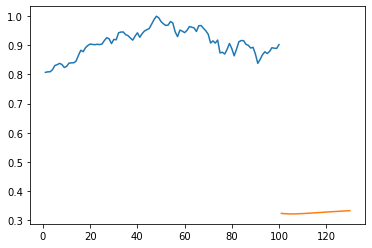

In [129]:
plt.plot(day_new,(df1[1375:]))
plt.plot(day_pred,(lst_output))